In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

First, we need to import our data into our system using `pd.read_csv()`.

Then, use `describe()` to see the analysis of the data.

In [2]:
file_path = "Social_Network_Ads.csv"
data = pd.read_csv(file_path)

data = data.dropna()[["Gender", "Age", "EstimatedSalary", "Purchased"]]
data['Gender'].replace(['Female','Male'],[0,1],inplace=True)

data.head()

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


From the table above, the column `TenYearCHD` is the column we need to predict using our model.

Now, we will start building our model from implementing the sigmoid function( or `sigmoid()`).

In [3]:
def sigmoid(z):
    """ 
    computes sigmoid of all elements in z.
    """
    return 1 / (1 + (np.power(np.e,-z, dtype="float64")))

Next, we will define cost function defined as follows.

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m}{[-y^{(i)}log(h_{\theta}(x^{(i)})) - (1 - y^{(i)})log(1 - h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^{n}{\theta_j^2}}$$

where $h_\theta(x) = \mbox{sigmoid}(x\theta)$

Note that our cost function $J(\theta)$ contains regularization term. This will allow us to get a simpler model.

`cost_function` should also return the gradient $\frac{\partial J(\theta)}{\partial \theta}$.


$$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})x_{j}^{(i)}} \quad\quad\quad\quad\quad\quad \mbox{for  } j = 0 $$

$$\frac{\partial J(\theta)}{\partial \theta_j} = \left(\frac{1}{m} \sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})x_{j}^{(i)}} \right) + \frac{\lambda}{m}\theta_j \quad\quad \mbox{for  } j \ge 1$$

In [4]:
def cost_function(X, y, theta, _lambda):
    """
    calculates cost function J based on parameter theta
    """
    m = y.size
    h = sigmoid(X @ theta)
    J = -(y*np.log(h+ 1e-5) + (1-y)*np.log(1 + 1e-5 -h)).mean() + _lambda * ((theta.T @ theta) - theta[0][0]**2) / (2*m)
    
    grad = (X.T @ (h-y)) / m
    
    return J, grad

By intuition, we know that linear combination of given features will not be a good hypothesis. Thus, making new quadratic features will help us build more accurate model.

In [5]:
def map_feature(X):
    features = np.ones((X.shape[0], 1))

    for i in range(X.shape[1]):
        features = np.column_stack((features, X[:, i]))
        for j in range(i, X.shape[1]):
            features = np.column_stack((features, X[:, i] * X[:, j]))
            for k in range(j, X.shape[1]):
                features = np.column_stack(
                    (features, X[:, i] * X[:, j] * X[:, k]))
                # for l in range(k, X.shape[1]):
                #     features = np.column_stack(
                #         (features, X[:, i] * X[:, j] * X[:, k] * X[:, l]))
                #     for m in range(l, X.shape[1]):
                #         features = np.column_stack(
                #             (features, X[:, i] * X[:, j] * X[:, k] * X[:, l] * X[:, m]))

    return features


In [6]:

data_np = data.copy().to_numpy()[:,1:3]

mu_data = []
sigma_data = []
for i in range(0, data_np.shape[1]):
    mu_data.append(data_np[:,i].mean())
    sigma_data.append(data_np[:,i].std())
    data_np[:,i] = (data_np[:,i] - mu_data[-1]) / (sigma_data[-1] + 1e-9)

X = map_feature(data_np)
theta = np.ones((X.shape[1], 1))
y = data[["Purchased"]].to_numpy()
_lambda = 0.0125

from sklearn.model_selection import train_test_split

mu = []
sigma = []

for i in range(1, X.shape[1]):
    mu.append(X[:,i].mean())
    sigma.append(X[:,i].std())
    X[:,i] = (X[:,i] - mu[-1]) / (sigma[-1] + 1e-9)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

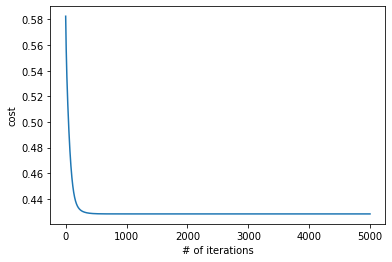

final J(theta) =  0.4283262575280381


In [7]:
xx = []
yy = []
        
for _ in range(5000):
    J, grad = cost_function(X_train, y_train, theta, _lambda)
    theta[1:] = (1-_lambda)*theta[1:] - 0.3*grad[1:]
    theta[0] = theta[0] - 0.1*grad[0]
    xx.append(_)
    yy.append(J[0][0])
plt.plot(xx,yy)
plt.xlabel("# of iterations")
plt.ylabel("cost")
plt.show()
print("final J(theta) = ", yy[-1])

In [8]:
def predict(X, theta):
    res = np.zeros((X.shape[0], 1))
    for i in range(X.shape[0]):
        h =sigmoid(X[i,:] @ theta)
        res[i,0] = (1 if h >= 0.65 else (0 if h <= 0.35 else 0.5))
    return res

In [9]:
prediction = predict(X_train, theta)

cnt = 0
not_classified = 0
for i in range(X_train.shape[0]):
    p = prediction[i,0]
    not_classified += p == 0.5
    cnt += (0 if abs(p - y_train[i,0]) == 1 else 1)

print("accuracy = ", cnt/X_train.shape[0])
print(cnt, "correct out of", X_train.shape[0],"with", not_classified,"by human")

accuracy =  0.8765822784810127
277 correct out of 316 with 51 by human


In [10]:
prediction = predict(X_test, theta)

cnt = 0
not_classified = 0
for i in range(X_test.shape[0]):
    p = prediction[i,0]
    not_classified += p == 0.5
    cnt += (0 if abs(p - y_test[i,0]) == 1 else 1)


print("accuracy = ", cnt/X_test.shape[0])
print(cnt, "correct out of", X_test.shape[0],"with", not_classified,"by human")

accuracy =  0.8690476190476191
73 correct out of 84 with 9 by human


[37.655, 69742.5]


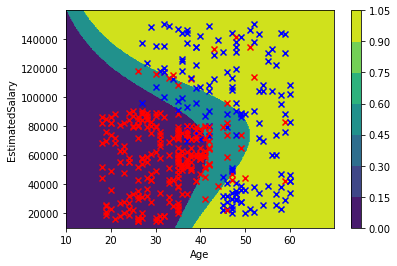

In [11]:
x = np.arange(10, 70, (70-10)/300)
y = np.arange(10000,160000,(160000-10000)/300)

print(mu_data)

x = (x - mu_data[0]) /(sigma_data[0] + 1e-9)
y = (y - mu_data[1]) /(sigma_data[1] + 1e-9)
x, y = np.meshgrid(x,y)

graph_X = map_feature(np.concatenate((x.reshape(90000,1),y.reshape(90000,1)), axis=1))
for i in range(1, X.shape[1]):
    graph_X[:,i] = (graph_X[:,i] - mu[i-1]) / (sigma[i-1] + 1e-9)

fig = plt.figure()
ax = fig.add_subplot()

c = ax.contourf(x*(sigma_data[0] + 1e-9) + mu_data[0], y*(sigma_data[1] + 1e-9) + mu_data[1], predict(graph_X, theta).reshape(300,300))
plt.colorbar(c)

for x, row in data.iterrows():
    ax.scatter( row["Age"], row["EstimatedSalary"], marker = "x", color='r' if row["Purchased"] == 0 else 'b')

ax.set_xlabel("Age")
ax.set_ylabel("EstimatedSalary")

plt.show()